In [55]:
import json
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
# from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import random
import warnings
warnings.filterwarnings('ignore')
from dataclasses import asdict

uploaded = pd.read_csv('/kaggle/input/shiftlogs/HomeWork.csv')

uploaded

,Unnamed: 0,status,income,age,date
0,0,Student,4000.0,18.0,2022-01-23
1,1,Pensioner,NaN,91.0,2022-01-19
2,2,Student,4000.0,18.0,2022-01-03
3,3,Student,0.0,NaN,2022-01-13
4,4,Pensioner,5000.0,87.0,2022-01-31
...,...,...,...,...,...
495,495,Pensioner,28000.0,NaN,2022-01-30
496,496,Pensioner,16000.0,64.0,2022-01-20
497,497,Businessman,258000.0,43.0,2022-01-12
498,498,Student,4000.0,17.0,2022-01-19


In [25]:
uploaded['status'].value_counts()

Student        145
Businessman    135
Pensioner      112
Working         98
Name: status, dtype: int64

<AxesSubplot:xlabel='income'>

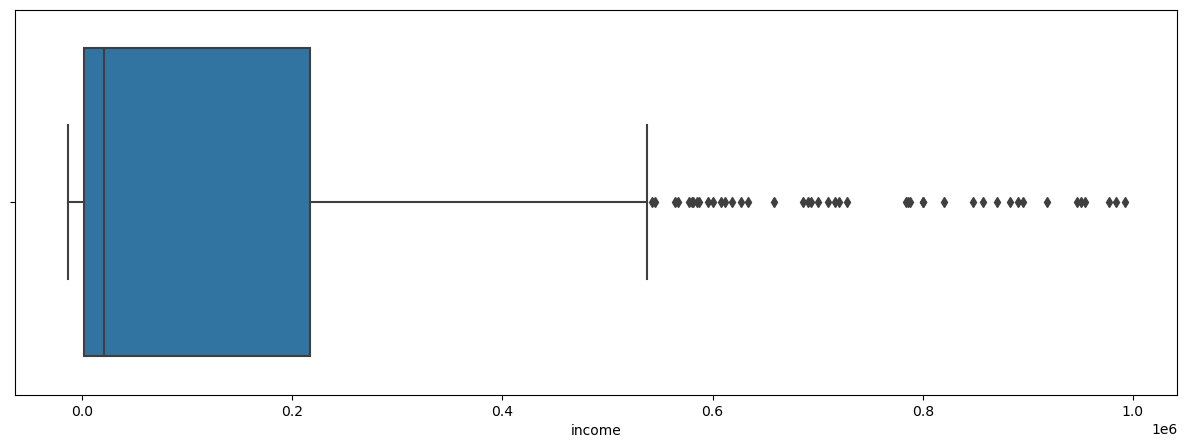

In [7]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=uploaded['income'])

In [4]:
def get_outliers_info(df, d = 1.5):
    """
    Статистика по наличию выбросов в признаках.
    df - датасет с признаками 
    d - коэффициент, на который умножается IQR (обычно 1.5, что соотв. усам на boxplot)
    """
    df = df.copy()
    q75 = df.quantile(0.75)
    q25 = df.quantile(0.25)
    iqr = q75 - q25

    feature_list, outlier_list = [], []
    numerical_columns = [c for c in df.columns if df[c].dtype in ['float64', 'int64'] and df[c].nunique()>10]

    for feature in numerical_columns:
        lower_threshold = q25.loc[feature] - d*iqr[feature]
        upper_threshold = q75.loc[feature] + d*iqr[feature]
        
        df['is_outlier'] = np.nan
        df.loc[(df[feature] < lower_threshold) | (df[feature] > upper_threshold), 'is_outlier'] = 1
        df['is_outlier'] = df['is_outlier'].fillna(0)

        feature_list.append(feature)
        outlier_list.append(df['is_outlier'].mean())
        
    outliers_df = pd.DataFrame(index=feature_list, data=outlier_list, columns=['ratio_outliers'])
    outliers_df = outliers_df[outliers_df['ratio_outliers']>0]
    outliers_df = outliers_df.sort_values(by='ratio_outliers', ascending=False)
    
    return outliers_df

In [5]:
outliers_df = get_outliers_info(uploaded)
outliers_df

,ratio_outliers
income,0.088


Функция и боксплот указывают на то, что выбросы имеются в колонке 'income'. Так как выбросы составляют 9% от общего числа, считаю для избежания перекоса работы модели заменить их на максимальный в боксплоте

In [12]:
def iqr_fence(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    Lower_Fence = Q1 - (1.5 * IQR)
    Upper_Fence = Q3 + (1.5 * IQR)
    u = max(x[x<Upper_Fence])
    l = min(x[x>Lower_Fence])
    print(u, l)
    return [u,l]

In [15]:
income = list(iqr_fence(uploaded['income']))

uploaded.loc[uploaded['income'] > income[0], 'income'] = income[0]

538000.0 -13745.0


538000.0

<AxesSubplot:xlabel='income'>

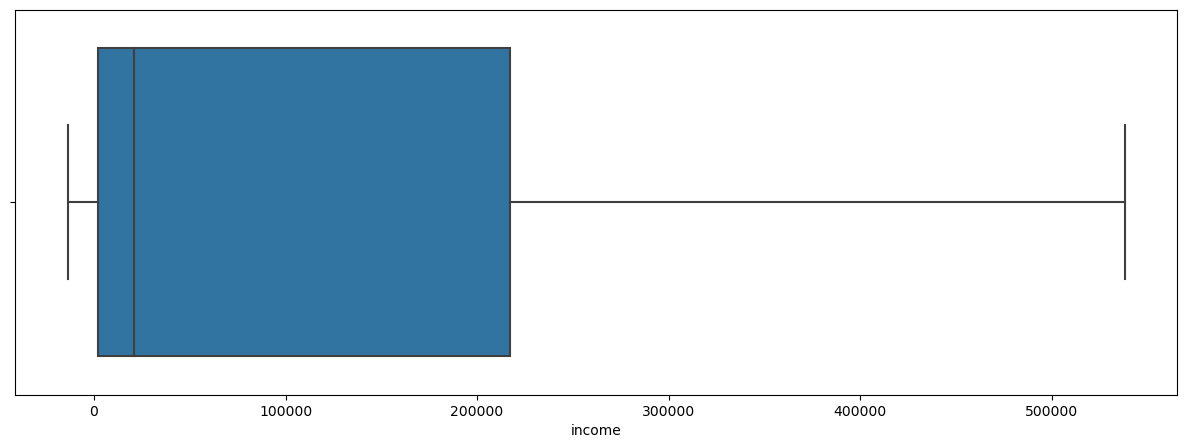

In [17]:
plt.figure(figsize=(15, 5))
sns.boxplot(x=uploaded['income'])

Пропуски в столбцах дохода и возраста предлагаю заполнить средним значением для каждой группы.

In [30]:
uploaded

0      18.000000
2      18.000000
3      20.056452
5      20.000000
6      22.000000
         ...    
478    18.000000
485    20.000000
488    20.056452
493    20.000000
498    17.000000
Name: age, Length: 145, dtype: float64

In [26]:
mean_income_Student = uploaded.loc[uploaded['status'] == 'Student', 'income'].mean()
mean_income_Pensioner = uploaded.loc[uploaded['status'] == 'Pensioner', 'income'].mean()
mean_income_Businessman = uploaded.loc[uploaded['status'] == 'Businessman', 'income'].mean()
mean_income_Working = uploaded.loc[uploaded['status'] == 'Working', 'income'].mean()

mean_age_Student = uploaded.loc[uploaded['status'] == 'Student', 'age'].mean()
mean_age_Pensioner = uploaded.loc[uploaded['status'] == 'Pensioner', 'age'].mean()
mean_age_Businessman = uploaded.loc[uploaded['status'] == 'Businessman', 'age'].mean()
mean_age_Working = uploaded.loc[uploaded['status'] == 'Working', 'age'].mean()

41.93333333333333

In [67]:
# почему-то эта строка не заменяет значения...
# uploaded.loc[uploaded['status'] == 'Pensioner', 'age'].fillna(mean_age_Pensioner, inplace = True)

uploaded['income'].fillna(value=uploaded['income'].mean(), inplace=True,)
uploaded['age'].fillna(value=uploaded['age'].mean(), inplace=True,)


uploaded

,Unnamed: 0,status,income,age,date
0,0,Student,4000.000000,18.000000,2022-01-23
1,1,Pensioner,152020.623256,91.000000,2022-01-19
2,2,Student,4000.000000,18.000000,2022-01-03
3,3,Student,0.000000,46.362812,2022-01-13
4,4,Pensioner,5000.000000,87.000000,2022-01-31
...,...,...,...,...,...
495,495,Pensioner,28000.000000,46.362812,2022-01-30
496,496,Pensioner,16000.000000,64.000000,2022-01-20
497,497,Businessman,258000.000000,43.000000,2022-01-12
498,498,Student,4000.000000,17.000000,2022-01-19


Пропуски в статусах заменяем наиболее встречающимся классом, так как их не много (10) и заполнение неизвестным классом смысла не имеет.


In [69]:
uploaded = uploaded.apply(lambda x: x.fillna(x.value_counts().index[0]))
uploaded

,Unnamed: 0,status,income,age,date
0,0,Student,4000.000000,18.000000,2022-01-23
1,1,Pensioner,152020.623256,91.000000,2022-01-19
2,2,Student,4000.000000,18.000000,2022-01-03
3,3,Student,0.000000,46.362812,2022-01-13
4,4,Pensioner,5000.000000,87.000000,2022-01-31
...,...,...,...,...,...
495,495,Pensioner,28000.000000,46.362812,2022-01-30
496,496,Pensioner,16000.000000,64.000000,2022-01-20
497,497,Businessman,258000.000000,43.000000,2022-01-12
498,498,Student,4000.000000,17.000000,2022-01-19


In [70]:
uploaded.isnull().sum()

Unnamed: 0    0
status        0
income        0
age           0
date          0
dtype: int64

In [ ]:
uploaded.to_csv('hw_32.csv')